The goal of this project is to write a data story on philosophy using the dataset for the Philosophy Data Project. Applying data mining, statistical analysis and visualization, students should derive interesting findings in this collection of philosophy texts and write a "data story" that can be shared with a general audience.

Challenge
In this project you will carry out an exploratory data analysis (EDA) of philosophy texts and write a blog on interesting findings from your analysis (i.e., a data story).

You are tasked to explore the text corpus using tools from data mining, statistical analysis and visualization, etc, all available in R or Python and write a blog post using R or Python Notebook. Your blog should be in the form of a data story blog on interesting trends and patterns identified by your analysis of these philosophy texts.

Even though this is an individual project, you are encouraged to discuss with your classmates and exchange ideas.

In [76]:
!pip3 install pandas
!pip3 install re
!pip3 install gensim
!pip3 install bs4
!pip3 install requests
!pip3 install fake_useragent
!pip3 install matplotlib_venn_wordcloud
!pip3 install wordcloud
!pip3 install pillow
!pip3 install wikipedia
!pip3 install matplotlib
!pip3 install numpy
!pip3 install dataframe-image
!pip3 install nltk
!pip3 install textblob
!pip3 install vaderSentiment

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
ERROR: Could not find a version that satisfies the requirement re (from versions: none)
ERROR: No matching distribution found for re
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated 

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [398]:
import pandas as pd
import re
import gensim
import gensim.corpora as corpora
from bs4 import BeautifulSoup
import requests
from fake_useragent import UserAgent
from matplotlib_venn_wordcloud import venn2_wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from gensim.models.coherencemodel import CoherenceModel
import wikipedia
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime
import dataframe_image as dfi
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [178]:
data = pd.read_csv('../data/philosophy_data.csv')

# define cleaning funcs

In [188]:
def write_to_output(df_in, df_name):
    path = f'../output/{df_name}.csv'
    df_in.to_csv(path, index=False)

In [7]:
def rem_sw(var_in):
    sw = stopwords.words('english')    
    clean_text = [word for word in var_in.split() if word not in sw]
    clean_text = ' '.join(clean_text)
    return clean_text
  
def clean_text(var_in):
    tmp = re.sub("[^A-Za-z]+", " ", var_in.lower())
    return tmp

def stem_fun(var):
    my_stem = PorterStemmer()
    tmp = [my_stem.stem(word) for word in var.split()]
    tmp = ' '.join(tmp)
    return tmp

# get wikipedia data

In [8]:
author_list = list(data.author.unique())
author_list.sort()

In [9]:
author_works_dict = {a: [] for a in author_list}

In [10]:
for index, row in data[['author','title']].drop_duplicates().reset_index(drop=True).iterrows():
    auth = row['author']
    titl = row['title']
    titl = titl.replace(auth, '')
    author_works_dict[auth].append(re.sub('[^A-Za-z0-9]+', ' ', titl.lower()))

In [11]:
author_school_dict = {a: list(data[data.author == a].school.unique())[0].lower() for a in author_list}

In [12]:
author_wiki_dict = {}

for author in author_list:
    print('running author: ' + author)
    author_titles = author_works_dict[author]
    author_school = author_school_dict[author]
    
    all_wiki_titles = wikipedia.search(f'philosopher {author} person')
    wiki_author_titles = [x for x in all_wiki_titles if author.lower() in x.lower() and 'surname' not in x]
    
    try:
        t = wiki_author_titles[0]
        print('page title: ' + t)
        content = (wikipedia.WikipediaPage(t).content).lower()
            
        boolean_ct = []
        for title in author_titles:
            boolean_ct.append(str(title in content))

        if (('True' in boolean_ct) or (author_school in content)):
            print(f'found page for {author}, it is {t}')
            author_wiki_dict[author] = content
        else:
            print(f'CANT FIND page for {author}')
            author_wiki_dict[author] = 'cant find page'
        
    except IndexError:
        print(f'cant even find title for {author}')
        author_wiki_dict[author] = 'cant find title'

running author: Aristotle
page title: Aristotle
found page for Aristotle, it is Aristotle
running author: Beauvoir
page title: Simone de Beauvoir
found page for Beauvoir, it is Simone de Beauvoir
running author: Berkeley
page title: George Berkeley
found page for Berkeley, it is George Berkeley
running author: Davis
page title: Angela Davis
found page for Davis, it is Angela Davis
running author: Deleuze
page title: Gilles Deleuze
found page for Deleuze, it is Gilles Deleuze
running author: Derrida
page title: Derrida
CANT FIND page for Derrida
running author: Descartes
page title: René Descartes
found page for Descartes, it is René Descartes
running author: Epictetus
page title: Epictetus
found page for Epictetus, it is Epictetus
running author: Fichte
page title: Johann Gottlieb Fichte
found page for Fichte, it is Johann Gottlieb Fichte
running author: Foucault
page title: Michel Foucault
found page for Foucault, it is Michel Foucault
running author: Hegel
page title: Georg Wilhelm F

In [13]:
missing_authors = [key for key, value in author_wiki_dict.items() if value == 'cant find page' or value == 'cant find title']

In [14]:
for author in missing_authors:
#     print('running author: ' + author)
    author_school = author_school_dict[author]
    author_titles = author_works_dict[author]
    
    all_titles = wikipedia.search(f'{author} philosopher')
    wiki_titles = [x for x in all_titles if author.lower() in x.lower() and 'surname' not in x]
    
    try:
        t = wiki_titles[0]
#         print('page title: ' + wiki_titles[0])
        content = (wikipedia.WikipediaPage(t).content).lower()
            
        boolean_ct = []
        for title in author_titles:
            boolean_ct.append(str(title in content))

        if ('True' in boolean_ct) or (author_school in content.lower()):
#             print(f'found page for {author}, it is {wiki_titles[0]}')
            author_wiki_dict[author] = content
        else:
#             print(f'CANT FIND page for {author}')
            author_wiki_dict[author] = 'cant find page'
        
    except IndexError:
#         print(f'cant even find title for {author}')
        author_wiki_dict[author] = 'cant find title'

running author: Derrida
page title: Jacques Derrida
found page for Derrida, it is Jacques Derrida
running author: Malebranche
page title: Nicolas Malebranche
found page for Malebranche, it is Nicolas Malebranche
running author: Popper
page title: Karl Popper
found page for Popper, it is Karl Popper
running author: Quine
page title: Willard Van Orman Quine
found page for Quine, it is Willard Van Orman Quine
running author: Ricardo
page title: Ricardo Guerra Tejada
CANT FIND page for Ricardo
running author: Russell
page title: Bertrand Russell's philosophical views
found page for Russell, it is Bertrand Russell's philosophical views


In [15]:
missing_authors_final = [key for key, value in author_wiki_dict.items() if value == 'cant find page' or value == 'cant find title']

In [16]:
if len(missing_authors_final) > 1:
    print('cant find wikipedia page for authors: {}'.format(', '.join(missing_authors_final)))
if len(missing_authors_final) == 1:
    print(f'cant find wikipedia page for author {missing_authors_final[0]}')

cant find wikipedia page for author Ricardo


In [17]:
# remove missing authors from dict
for author in missing_authors_final:
    author_wiki_dict.pop(author)

In [18]:
# remove missing authors from author list
for author in missing_authors_final:
    author_list.remove(author)

In [179]:
# remove missing authors from data
data = data[~data.author.isin(missing_authors_final)].reset_index(drop=True)

In [20]:
# apply cleaning functions to author wiki pages
author_wiki_df = pd.DataFrame(author_wiki_dict.items(), columns = ['author','content'])
author_wiki_df = author_wiki_df[~author_wiki_df.author.isin(missing_authors_final)]
author_wiki_df["content_lowered"] = author_wiki_df.content.apply(
    lambda x: x.lower()
)
author_wiki_df["clean_text"] = author_wiki_df.content_lowered.apply(clean_text)
author_wiki_df["rem_sw"] = author_wiki_df.clean_text.apply(rem_sw)
author_wiki_df["rem_sw_stem"] = author_wiki_df.rem_sw.apply(stem_fun)

# get author sexes

In [21]:
sex_dict = {a: [] for a in author_list}

In [22]:
female_pronouns = ['she','her','hers']
male_pronouns = ['he','him','his']

In [23]:
sex_dict = {}
for author, content in author_wiki_dict.items():
    female = sum([1 for word in content.split() if word in (female_pronouns)])
    male = sum([1 for word in content.split() if word in (male_pronouns)])
    if abs(female - male) < 5:
        print(f'author {author} has less than 5 diff')
        sex_dict[author] = {'female': female,
                            'male': male}
    elif female > male:
        sex_dict[author] = 'female'
    elif male > female:
        sex_dict[author] = 'male'

In [180]:
# add sexes to data
data['sex'] = data.author.apply(lambda x: sex_dict[x])
author_wiki_df['sex'] = author_wiki_df.author.apply(lambda x: sex_dict[x])

# get google results for each author

In [48]:
def my_scraper(tmp_url_in):
    tmp_text = ''
    try:
        content = requests.get(tmp_url_in, timeout=10)
        soup = BeautifulSoup(content.text, 'html.parser')

        tmp_text = soup.findAll('p') 

        tmp_text = [word.text for word in tmp_text]
        tmp_text = ' '.join(tmp_text)
        tmp_text = re.sub('\W+', ' ', re.sub('xa0', ' ', tmp_text))
    except requests.exceptions.Timeout:
        pass
    return tmp_text

def fetch_urls(query_tmp, cnt):
    ua = UserAgent()

    query = '+'.join(query_tmp.split())
    google_url = "https://www.google.com/search?q=" + query + "&num=" + str(cnt)
    response = requests.get(google_url, {"User-Agent": ua.random})
    soup = BeautifulSoup(response.text, "html.parser")

    result_div = soup.find_all('div', attrs = {'class': 'ZINbbc'})

    links = []
    titles = []
    descriptions = []
    for r in result_div:
        try:
            link = r.find('a', href = True)
            title = r.find('div', attrs={'class':'vvjwJb'}).get_text()
            description = r.find('div', attrs={'class':'s3v9rd'}).get_text()
            if link != '' and title != '' and description != '': 
                links.append(link['href'])
                titles.append(title)
                descriptions.append(description)
        except:
            continue  

    to_remove = []
    clean_links = []
    for i, l in enumerate(links):
        clean = re.search('\/url\?q\=(.*)\&sa',l)
        if clean is None:
            to_remove.append(i)
            continue
        clean_links.append(clean.group(1))

    return clean_links

def write_crawl_results(my_query, the_cnt_in):
    tmp_pd = pd.DataFrame()       
    for q_blah in my_query:
        the_urls_list = fetch_urls(q_blah, the_cnt_in)

        for word in the_urls_list:
            tmp_txt = my_scraper(word)
            if len(tmp_txt) != 0:
                try:
                    tmp_pd = tmp_pd.append(
                        {
                            'body_basic': tmp_txt,
                            'author': q_blah.replace('philosopher ', '').replace(' review',''),
                            'link': word
                        },
                        ignore_index=True)
                except:
                    pass
    return tmp_pd

In [49]:
query_tmp = "philosopher marcus aurelius review"
query = '+'.join(query_tmp.split())
google_url = "https://www.google.com/search?q=" + query + "&num=" + '15'
ua = UserAgent()
response = requests.get(google_url, {"User-Agent": ua.random})

In [50]:
google_data = pd.DataFrame([])
for author in author_list:
    google_data = google_data.append(write_crawl_results([f"philosopher {author} review"], 10))

In [51]:
google_data = google_data[~google_data.author.isin(missing_authors_final)]

In [52]:
google_data["sentence_lowered"] = google_data.body_basic.apply(
    lambda x: x.lower()
)
google_data["clean_text"] = google_data.sentence_lowered.apply(clean_text)
google_data["rem_sw"] = google_data.clean_text.apply(rem_sw)
google_data["rem_sw_stem"] = google_data.rem_sw.apply(stem_fun)

In [54]:
google_data['sex'] = google_data.author.apply(lambda x: sex_dict[x])

# Run Sentiment Analysis

Define functions

In [55]:
def gen_senti(arbitrary_text):
    '''
    Tokenizes arbitrary text and compares each token with the positive and 
    negative lexicons of each dictionary and outputs the sentiment score, S
    '''
    arbitrary_text_clean = re.sub(r'[^a-zA-Z ]+', '', arbitrary_text)
    arbitrary_text_list = arbitrary_text_clean.split()
    
    pw = [-1 for word in arbitrary_text_list if word in (pos_neg_dict['negative-words'])]
    nw = [1 for word in arbitrary_text_list if word in (pos_neg_dict['positive-words'])]
    pc = len(pw)
    nc = len(nw)
    total = pc + nc
    try:
        S = (sum(pw) + sum(nw)) / total
    except ZeroDivisionError:
        S = None
    return S
def gen_textblob_senti(var_in):
    blob = TextBlob(var_in)
    return blob.sentiment.polarity

Apply to data

In [182]:
data["sentence_lowered"] = data.sentence_str.apply(
    lambda x: x.lower()
)
data["clean_text"] = data.sentence_lowered.apply(clean_text)
data["rem_sw"] = data.clean_text.apply(rem_sw)
data["rem_sw_stem"] = data.rem_sw.apply(stem_fun)

In [57]:
# read and save sentiment dictionaries into pos_neg_dict
file_names = ['positive-words', 'negative-words']
pos_neg_dict = {}
for file in file_names:
    path = "../data/{}.txt".format(
        file
    )
    with open(path, "r", encoding="ISO-8859-1") as f:
        contents = []
        for line in f:
            line = line.strip()
            contents.append(line)
    f.close()
    pos_neg_dict[file] = contents

In [ ]:
data['simple_senti'] = data.rem_sw_stem.apply(gen_senti)
data['textblob_senti'] = data.rem_sw_stem.apply(gen_textblob_senti)

vaderSent = SentimentIntensityAnalyzer()
data['vader'] = data.rem_sw_stem.apply(
    lambda x: vaderSent.polarity_scores(x)['compound']
)

In [64]:
write_to_output(data, 'data')

Apply to author wiki data

In [59]:
author_wiki_df['simple_senti'] = author_wiki_df.rem_sw_stem.apply(gen_senti)
author_wiki_df['textblob_senti'] = author_wiki_df.rem_sw_stem.apply(gen_textblob_senti)

vaderSent = SentimentIntensityAnalyzer()
author_wiki_df['vader'] = author_wiki_df.rem_sw_stem.apply(
    lambda x: vaderSent.polarity_scores(x)['compound']
)

In [65]:
write_to_output(author_wiki_df, 'author_wiki_df')

Apply to google data

In [60]:
google_data['simple_senti'] = google_data.rem_sw_stem.apply(gen_senti)
google_data['textblob_senti'] = google_data.rem_sw_stem.apply(gen_textblob_senti)

vaderSent = SentimentIntensityAnalyzer()
google_data['vader'] = google_data.rem_sw_stem.apply(
    lambda x: vaderSent.polarity_scores(x)['compound']
)

In [66]:
write_to_output(google_data, 'google_data')

# LDA Topic Modeling

In [61]:
# def lda_fun(df_in, n_topics_in, num_words_in):
#     data_tmp = df_in.str.split()
#     id2word = corpora.Dictionary(data_tmp)
    
#     corpus = [id2word.doc2bow(text) for text in data_tmp]

#     ldamodel = gensim.models.ldamodel.LdaModel(
#         corpus, num_topics=n_topics_in, id2word=id2word, passes=15)
# #     ldamodel.save('model5.gensim')
#     topics = ldamodel.print_topics(num_words=num_words_in)
# #     print('\nPerplexity: ', ldamodel.log_perplexity(corpus))  
#     coherence_model_lda = CoherenceModel(
#         model=ldamodel, texts=data_tmp, dictionary=id2word, coherence='c_v')
#     coherence_lda = coherence_model_lda.get_coherence()
# #     print('\nCoherence Score: ', coherence_lda)
#     for topic in topics:
#         print(topic)
#     return topics

In [70]:
# lda_author_topics_dict = {}

# for author in author_list:
#     print(f'running {author}')
#     author_data = data[data['author'] == author]
#     author_data_drop_na = author_data[~author_data.rem_sw_stem.isna()]
#     the_topics = lda_fun(author_data_drop_na.rem_sw_stem, 2, 5)
#     lda_author_topics_dict[author] = the_topics

# # write lda_author_topics_dict to output
# lda_author_topics_df_raw = pd.DataFrame(lda_author_topics_dict)
# lda_author_topics_df = lda_author_topics_df_raw.unstack().reset_index().drop('level_1', axis=1).rename(
#     columns = {'level_0':'author',
#                '0':'topic'}
# )

# lda_author_topics_df['sex'] = lda_author_topics_df.author.apply(lambda x: sex_dict[x])

# write_to_output(lda_author_topics_df, 'lda_author_topics_df')

running Aristotle
(0, '0.024*"one" + 0.018*"thing" + 0.014*"must" + 0.012*"good" + 0.011*"man"')
(1, '0.008*"like" + 0.006*"anim" + 0.006*"men" + 0.006*"also" + 0.005*"feel"')
running Beauvoir
(0, '0.008*"one" + 0.008*"girl" + 0.007*"like" + 0.007*"women" + 0.007*"littl"')
(1, '0.024*"woman" + 0.013*"man" + 0.010*"love" + 0.009*"one" + 0.008*"women"')
running Berkeley
(0, '0.035*"idea" + 0.027*"exist" + 0.022*"mind" + 0.021*"thing" + 0.021*"perceiv"')
(1, '0.017*"natur" + 0.009*"may" + 0.008*"use" + 0.007*"principl" + 0.007*"part"')
running Davis
(0, '0.012*"black" + 0.010*"rape" + 0.006*"woman" + 0.006*"lynch" + 0.006*"women"')
(1, '0.044*"women" + 0.018*"black" + 0.015*"white" + 0.011*"work" + 0.008*"men"')
running Deleuze
(0, '0.017*"differ" + 0.011*"relat" + 0.009*"determin" + 0.008*"one" + 0.008*"form"')
(1, '0.015*"desir" + 0.011*"social" + 0.011*"machin" + 0.010*"product" + 0.010*"flow"')
running Derrida
(0, '0.012*"write" + 0.010*"mean" + 0.007*"must" + 0.007*"within" + 0.007*"

In [ ]:
# lda_school_topics_dict = {}
# for school in school_list:
#     print(f'running {school}')
#     the_topics = lda_fun(data[data['school'] == school].rem_sw_stem, 2, 5)
#     lda_school_topics_dict[school] = the_topics

# lda_school_topics_df_raw = pd.DataFrame(lda_school_topics_dict)
# lda_school_topics_df = lda_school_topics_df_raw.unstack().reset_index().drop('level_1', axis=1).rename(
#     columns = {'level_0':'author',
#                '0':'topic'}
# )


# lda_school_topics_df.to_csv('../output/lda_school_topics_df.csv')

In [71]:
# lda_author_wiki_topics_dict = {}

# for author in author_list:
#     print(f'running {author}')
#     author_wiki_data = author_wiki_df[author_wiki_df['author'] == author]
#     author_wiki_data_drop_na = author_wiki_data[~author_wiki_data.rem_sw_stem.isna()]
#     the_topics = lda_fun(author_wiki_data_drop_na.rem_sw_stem, 2, 5)
#     lda_author_wiki_topics_dict[author] = the_topics

# lda_author_wiki_topics_df_raw = pd.DataFrame(lda_author_wiki_topics_dict)
# lda_author_wiki_topics_df = lda_author_wiki_topics_df_raw.unstack().reset_index().drop('level_1', axis=1).rename(
#     columns = {'level_0':'author',
#                '0':'topic'}
# )

# lda_author_wiki_topics_df['sex'] = lda_author_wiki_topics_df.author.apply(lambda x: sex_dict[x])
# write_to_output(lda_author_wiki_topics_df, 'lda_author_wiki_topics_df')

running Aristotle
(0, '0.036*"aristotl" + 0.007*"work" + 0.006*"form" + 0.006*"one" + 0.005*"natur"')
(1, '0.001*"aristotl" + 0.001*"work" + 0.001*"form" + 0.001*"one" + 0.001*"philosoph"')
running Beauvoir
(0, '0.037*"beauvoir" + 0.014*"sartr" + 0.012*"de" + 0.011*"simon" + 0.008*"le"')
(1, '0.001*"beauvoir" + 0.001*"de" + 0.001*"sartr" + 0.001*"simon" + 0.001*"le"')
running Berkeley
(0, '0.001*"berkeley" + 0.001*"perceiv" + 0.001*"idea" + 0.001*"philosophi" + 0.001*"georg"')
(1, '0.041*"berkeley" + 0.012*"perceiv" + 0.010*"idea" + 0.008*"exist" + 0.008*"object"')
running Davis
(0, '0.001*"davi" + 0.001*"angela" + 0.001*"prison" + 0.001*"univers" + 0.001*"black"')
(1, '0.036*"davi" + 0.012*"angela" + 0.010*"univers" + 0.009*"black" + 0.008*"prison"')
running Deleuze
(0, '0.033*"deleuz" + 0.013*"philosophi" + 0.011*"spinoza" + 0.011*"differ" + 0.007*"tran"')
(1, '0.001*"deleuz" + 0.001*"differ" + 0.001*"spinoza" + 0.001*"philosophi" + 0.001*"philosoph"')
running Derrida
(0, '0.001*"der

In [72]:
# lda_author_google_topics_dict = {}

# for author in author_list:
#     print(f'running {author}')
#     google_author_data = google_data[google_data['author'] == author]
#     google_author_data_drop_na = google_author_data[~google_author_data.rem_sw_stem.isna()]
#     the_topics = lda_fun(google_author_data_drop_na.rem_sw_stem, 2, 5)
#     lda_author_google_topics_dict[author] = the_topics

# # write lda_author_google_topics_df to output
# lda_author_google_topics_df_raw = pd.DataFrame(lda_author_google_topics_dict)
# lda_author_google_topics_df = lda_author_google_topics_df_raw.unstack().reset_index().drop('level_1', axis=1).rename(
#     columns = {'level_0':'author',
#                '0':'topic'}
# )
# lda_author_google_topics_df['sex'] = lda_author_google_topics_df.author.apply(lambda x: sex_dict[x])
# write_to_output(lda_author_google_topics_df, 'lda_author_google_topics_df')

running Aristotle
(0, '0.028*"aristotl" + 0.006*"form" + 0.006*"b" + 0.006*"human" + 0.005*"philosoph"')
(1, '0.026*"aristotl" + 0.014*"one" + 0.010*"b" + 0.007*"form" + 0.006*"natur"')
running Beauvoir
(0, '0.023*"beauvoir" + 0.010*"women" + 0.007*"freedom" + 0.007*"second" + 0.006*"sex"')
(1, '0.023*"beauvoir" + 0.011*"sartr" + 0.006*"kirkpatrick" + 0.005*"one" + 0.005*"de"')
running Berkeley
(0, '0.034*"berkeley" + 0.018*"idea" + 0.013*"perceiv" + 0.012*"object" + 0.010*"exist"')
(1, '0.016*"berkeley" + 0.009*"jone" + 0.007*"life" + 0.006*"philosoph" + 0.006*"georg"')
running Davis
(0, '0.014*"davi" + 0.006*"book" + 0.006*"dick" + 0.005*"author" + 0.004*"larb"')
(1, '0.026*"philosophi" + 0.014*"class" + 0.008*"davi" + 0.005*"philosoph" + 0.005*"one"')
running Deleuze
(0, '0.023*"deleuz" + 0.009*"differ" + 0.008*"philosophi" + 0.007*"one" + 0.006*"guattari"')
(1, '0.026*"deleuz" + 0.011*"letter" + 0.009*"guattari" + 0.008*"book" + 0.008*"one"')
running Derrida
(0, '0.030*"derrida" + 

# Analysis

In [266]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)
pd.options.display.float_format = '{:,}'.format

### Descriptive figs

In [73]:
author_dates = data[['author','original_publication_date']].groupby(['author']).max('original_publication_date').join(
    data[['author','original_publication_date']].groupby(['author']).min('original_publication_date'),
    lsuffix = '_max',
    rsuffix = '_min'
)

author_dates.reset_index(inplace = True)

In [ ]:
author_dates['sex'] = author_dates.author.apply(lambda x: sex_dict[x])

In [466]:
def display_descriptive_counts(**kwargs):
    count_records = pd.DataFrame(data.groupby(['sex']).size(), columns = ['records'])
    count_unique_authors = pd.DataFrame(data.groupby('sex')['author'].nunique())
    count_unique_titles = pd.DataFrame(data.groupby('sex')['title'].nunique())
    count_unique_schools = pd.DataFrame(data.groupby('sex')['school'].nunique())
    
    descriptive_cts_df = count_unique_authors.join(count_unique_titles).join(count_records).join(count_unique_schools)
    descriptive_cts_df.columns = ['authors','titles','records', 'schools']
    
    display(descriptive_cts_df)

In [467]:
# display_descriptive_counts()

authors  titles  records  schools
sex                                      
female     3        3     18635      1   
male      32       55    339083     12

In [471]:
# men do all but one school (feminism) and women only do one school (feminism)

In [146]:
male_names = list(author_dates[author_dates.sex=='male']['author'])
male_dates = list(author_dates[(author_dates.sex=='male')]['original_publication_date_min'])

female_names = list(author_dates[author_dates.sex=='female']['author'])
female_dates = list(author_dates[(author_dates.sex=='female')]['original_publication_date_min'])

In [174]:
def plot_timelines(**kwargs):
    ### MALES ###
    levels = np.tile([-5, 5, -3, 3, -1, -1],
                     int(np.ceil(len(male_dates)/6)))[:len(male_dates)]

    # Create figure and plot a stem plot with the date
    f,(ax,ax2) = plt.subplots(1,2,
                              sharey=True,
                              facecolor='w',
                              figsize=(20, 8),
                              constrained_layout=True)

    f.suptitle("Male Author First Original Publication Date", fontsize=25)

    ax.vlines(male_dates, 0, levels, color="tab:blue")  # The vertical stems.
    ax.plot(male_dates,
            np.zeros_like(male_dates),
            "-o",
            color="k",
            markerfacecolor="w")  # Baseline and markers on it.
    ax.set_xlim(-400,500)

    ax2.vlines(male_dates, 0, levels, color="tab:blue")  # The vertical stems.
    ax2.plot(male_dates,
            np.zeros_like(male_dates),
            "-o",
            color="k",
            markerfacecolor="w")  # Baseline and markers on it.
    ax2.set_xlim(1500,2020)


    # annotate lines
    for d, l, r in zip(male_dates, levels, male_names):
        ax.annotate(r, xy=(d, l),
                    xytext=(-3, np.sign(l)*3),
                    textcoords="offset points",
                    rotation=60,
                    horizontalalignment="right",
                    verticalalignment="bottom" if l > 0 else "top")

    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

    for d, l, r in zip(male_dates, levels, male_names):
        ax2.annotate(r, xy=(d, l),
                    xytext=(-3, np.sign(l)*3),
                    textcoords="offset points",
                    rotation=90,
                    horizontalalignment="right",
                    verticalalignment="bottom" if l > 0 else "top")

    plt.setp(ax2.get_xticklabels(), rotation=30, ha="right")

    # CITATION: https://stackoverflow.com/questions/32185411/break-in-x-axis-of-matplotlib
    ax.yaxis.set_visible(False)
    ax.spines[["left", "top", "right"]].set_visible(False)

    ax2.yaxis.set_visible(False)
    ax2.spines[["left", "top", "right"]].set_visible(False)

    ax.margins(y=0.1)
    ax2.margins(y=0.1)

    d = .015 

    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((1-d,1+d), (-d,+d), **kwargs)
    # ax.plot((1-d,1+d),(1-d,1+d), **kwargs)

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    # ax2.plot((-d,+d), (1-d,1+d), **kwargs)
    ax2.plot((-d,+d), (-d,+d), **kwargs)

    plt.savefig('../figs/male_timeline_plot.png')
    plt.show()

    ### FEMALES ###
    levels = np.tile([-5, 5, -3, 3, -1, -1],
                     int(np.ceil(len(female_dates)/6)))[:len(female_dates)]

    fig, ax = plt.subplots(
        figsize=(8, 6),
        constrained_layout=True
    )

    fig.suptitle("Female Author First Original Publication Date", fontsize=16)

    ax.vlines(female_dates, 0, levels, color="tab:pink")  # The vertical stems.
    ax.plot(female_dates,
            np.zeros_like(female_dates),
            "-o",
            color="k",
            markerfacecolor="w")  # Baseline and markers on it.
    ax.set_xlim(1700, 2000)
    ax.yaxis.set_visible(False)
    ax.spines[["left", "top", "right"]].set_visible(False)

    # annotate lines
    for d, l, r in zip(female_dates, levels, female_names):
        ax.annotate(r, xy=(d, l),
                    xytext=(-3, np.sign(l)*3),
                    textcoords="offset points",
                    rotation=0,
                    horizontalalignment="right",
                    verticalalignment="bottom" if l > 0 else "top")

    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
    plt.savefig('../figs/female_timeline_plot.png')
    plt.show()

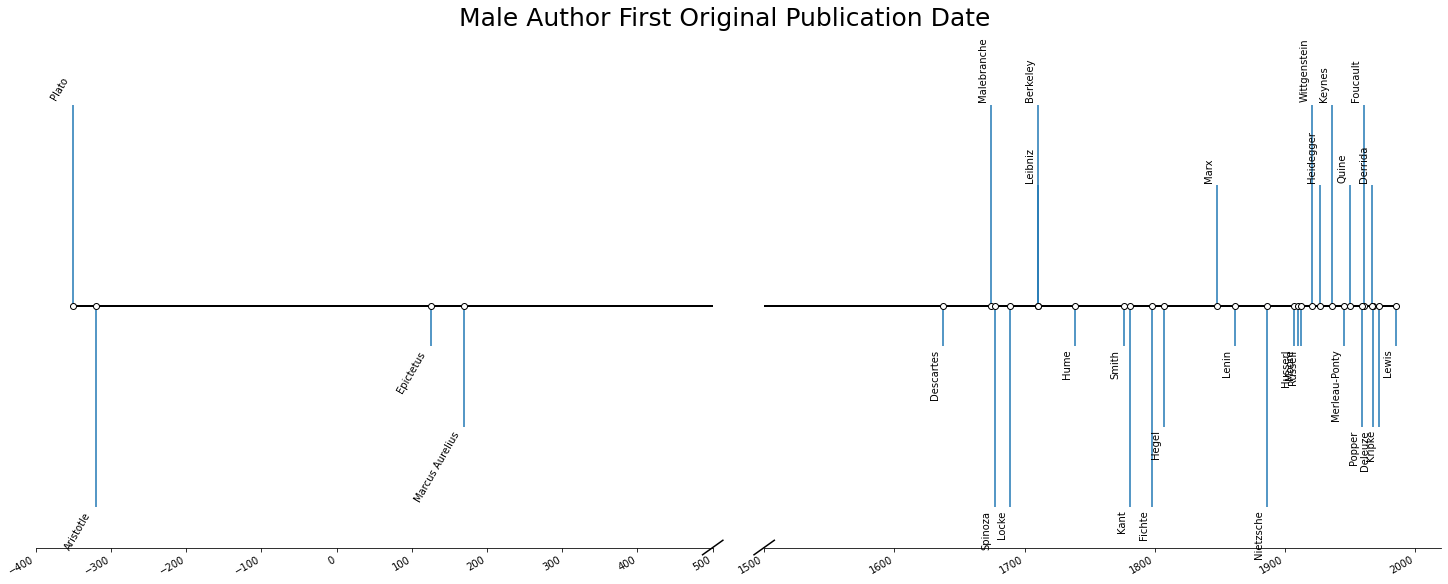

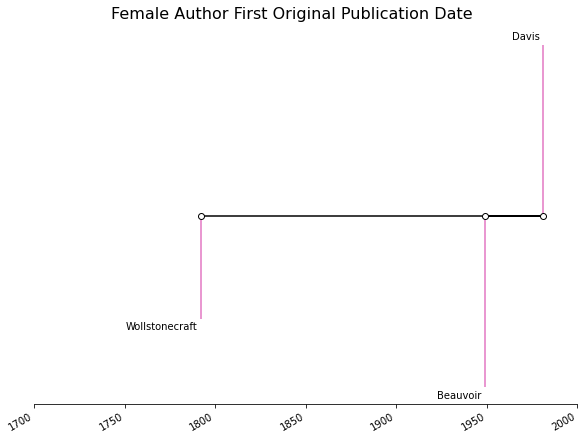

In [468]:
# plot_timelines()

### sentiment by gender (for works and wiki)

In [241]:
def plot_senti_scores_data(**kwargs):
    ### OG DATA ###
    labels = ['simple senti', 'vader senti', 'textblob senti']
    gpd_data = data.groupby(['sex']).mean()[['simple_senti','vader','textblob_senti']].reset_index()
    
    men_means = list(round(gpd_data[gpd_data.sex=='male'][['simple_senti','vader','textblob_senti']].iloc[0],4))
    women_means = list(round(gpd_data[gpd_data.sex=='female'][['simple_senti','vader','textblob_senti']].iloc[0],4))

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(8, 6))
        
    rects1 = ax.bar(x - width/2, men_means, width, label='Men', color = 'blue')
    rects2 = ax.bar(x + width/2, women_means, width, label='Women', color = 'pink')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title('philosophy data sentiment scores', size = 16)
    
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()
    plt.savefig('../figs/philosophy_senti_scores.png')
    plt.show()

def plot_senti_scores_wiki(**kwargs):
    ### WIKI DATA ###
    labels = ['simple senti', 'vader senti', 'textblob senti']
    gpd_data = author_wiki_df.groupby(['sex']).mean()[['simple_senti','vader','textblob_senti']].reset_index()
    
    men_means = list(round(gpd_data[gpd_data.sex=='male'][['simple_senti','vader','textblob_senti']].iloc[0],4))
    women_means = list(round(gpd_data[gpd_data.sex=='female'][['simple_senti','vader','textblob_senti']].iloc[0],4))

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(8, 6))

    rects1 = ax.bar(x - width/2, men_means, width, label='Men', color = 'blue')
    rects2 = ax.bar(x + width/2, women_means, width, label='Women', color = 'pink')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title('wikipedia data sentiment scores', size = 16)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()
    plt.savefig('../figs/wikipedia_senti_scores.png')
    plt.show()

def plot_senti_scores_google(**kwargs):
    ### GOOGLE DATA ###
    labels = ['simple senti', 'vader senti', 'textblob senti']
    gpd_data = google_data.groupby(['sex']).mean()[['simple_senti','vader','textblob_senti']].reset_index()
    
    men_means = list(round(gpd_data[gpd_data.sex=='male'][['simple_senti','vader','textblob_senti']].iloc[0],4))
    women_means = list(round(gpd_data[gpd_data.sex=='female'][['simple_senti','vader','textblob_senti']].iloc[0],4))

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(8, 6))

    rects1 = ax.bar(x - width/2, men_means, width, label='Men', color = 'blue')
    rects2 = ax.bar(x + width/2, women_means, width, label='Women', color = 'pink')

    ax.set_ylabel('Scores')
    ax.set_title('google data sentiment scores', size = 16)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()
    plt.savefig('../figs/google_senti_scores.png')
    plt.show()

### wordclouds of data

In [446]:
def wordcloud_data(**kwargs):
    women_text = ' '.join(list(data[(data.sex=='female') & (~data.rem_sw.isna())].rem_sw))
    men_text = ' '.join(list(data[(data.sex=='male') & (~data.rem_sw.isna())].rem_sw))

    women_coloring = np.array(Image.open("../figs/women.png"))
    men_coloring = np.array(Image.open("../figs/men2.png"))


    wc_women = WordCloud(background_color="white",
                         max_words=200,
                         mask=women_coloring,
                         max_font_size=50,
                         random_state=123)
    wc_men = WordCloud(background_color="white",
                         max_words=1000,
                         mask=men_coloring,
                         max_font_size=50,
                         random_state=123)
    # generate word cloud
    wc_women.generate(women_text)
    wc_men.generate(men_text)

    # create coloring from image
    women_image_colors = ImageColorGenerator(women_coloring)
    men_image_colors = ImageColorGenerator(men_coloring)

    fig, ax = plt.subplots(1,2,figsize=(20,20))

    ax[0].imshow(wc_women.recolor(color_func=women_image_colors), interpolation="bilinear")
    ax[0].set_axis_off()

    ax[1].imshow(wc_men.recolor(color_func=men_image_colors), interpolation="bilinear")
    ax[1].set_axis_off()
    plt.show()

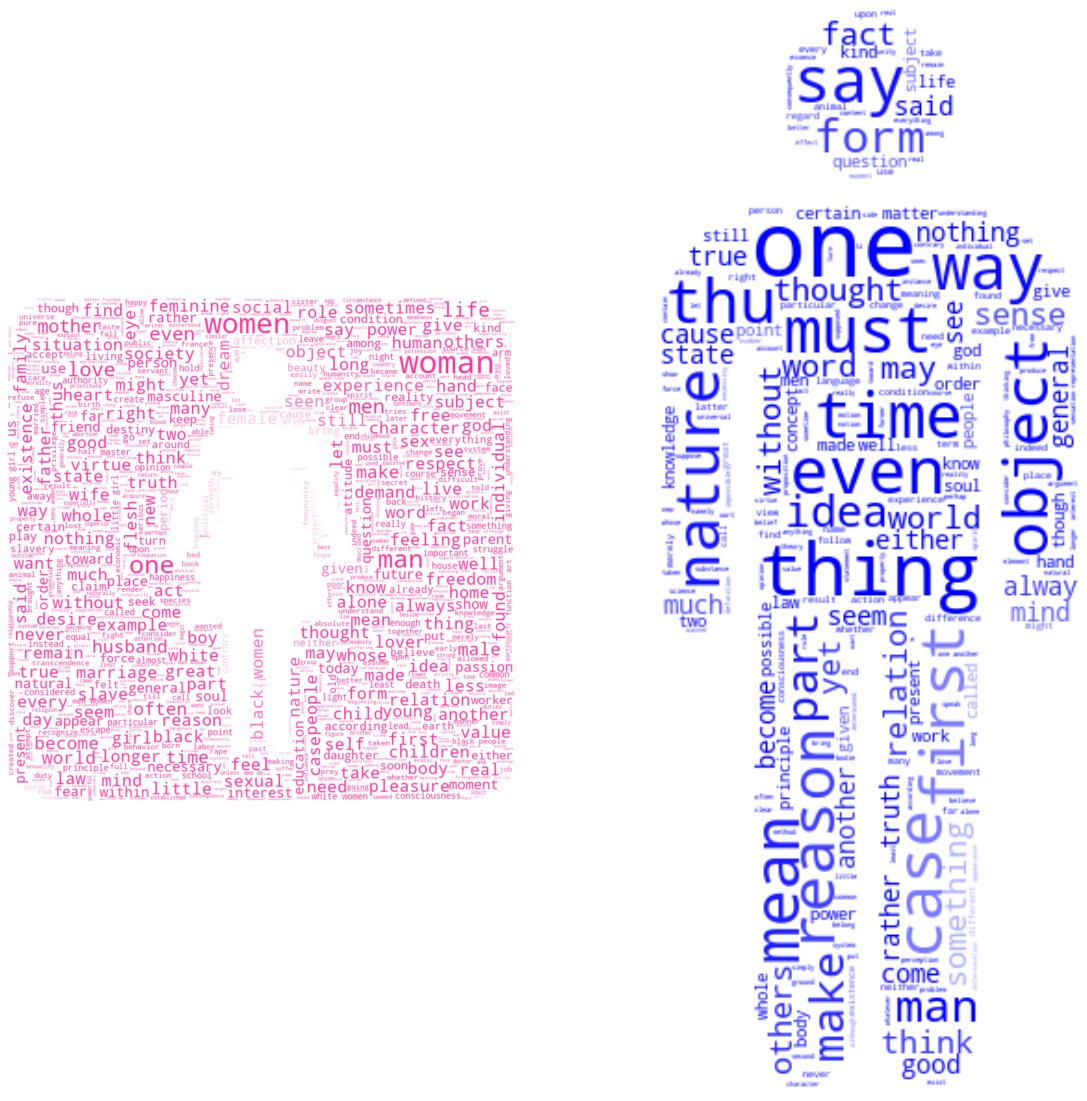

In [447]:
# wordcloud_data()

In [449]:
def wordcloud_wikipedia(**kwargs):    
    women_text = ' '.join(list(author_wiki_df[(author_wiki_df.sex=='female') & (~author_wiki_df.rem_sw.isna())].rem_sw))
    men_text = ' '.join(list(author_wiki_df[(author_wiki_df.sex=='male') & (~author_wiki_df.rem_sw.isna())].rem_sw))

    women_coloring = np.array(Image.open("../figs/women.png"))
    men_coloring = np.array(Image.open("../figs/men2.png"))

    wc_women = WordCloud(background_color="white",
                         max_words=250,
                         mask=women_coloring,
                         max_font_size=50,
                         random_state=123)
    wc_men = WordCloud(background_color="white",
                         max_words=1000,
                         mask=men_coloring,
                         max_font_size=50,
                         random_state=123)
    # generate word cloud
    wc_women.generate(women_text)
    wc_men.generate(men_text)

    # create coloring from image
    women_image_colors = ImageColorGenerator(women_coloring)
    men_image_colors = ImageColorGenerator(men_coloring)

    fig, ax = plt.subplots(1,2,figsize=(20,20))

    ax[0].imshow(wc_women.recolor(color_func=women_image_colors), interpolation="bilinear")
    ax[0].set_axis_off()

    ax[1].imshow(wc_men.recolor(color_func=men_image_colors), interpolation="bilinear")
    ax[1].set_axis_off()
    plt.show()

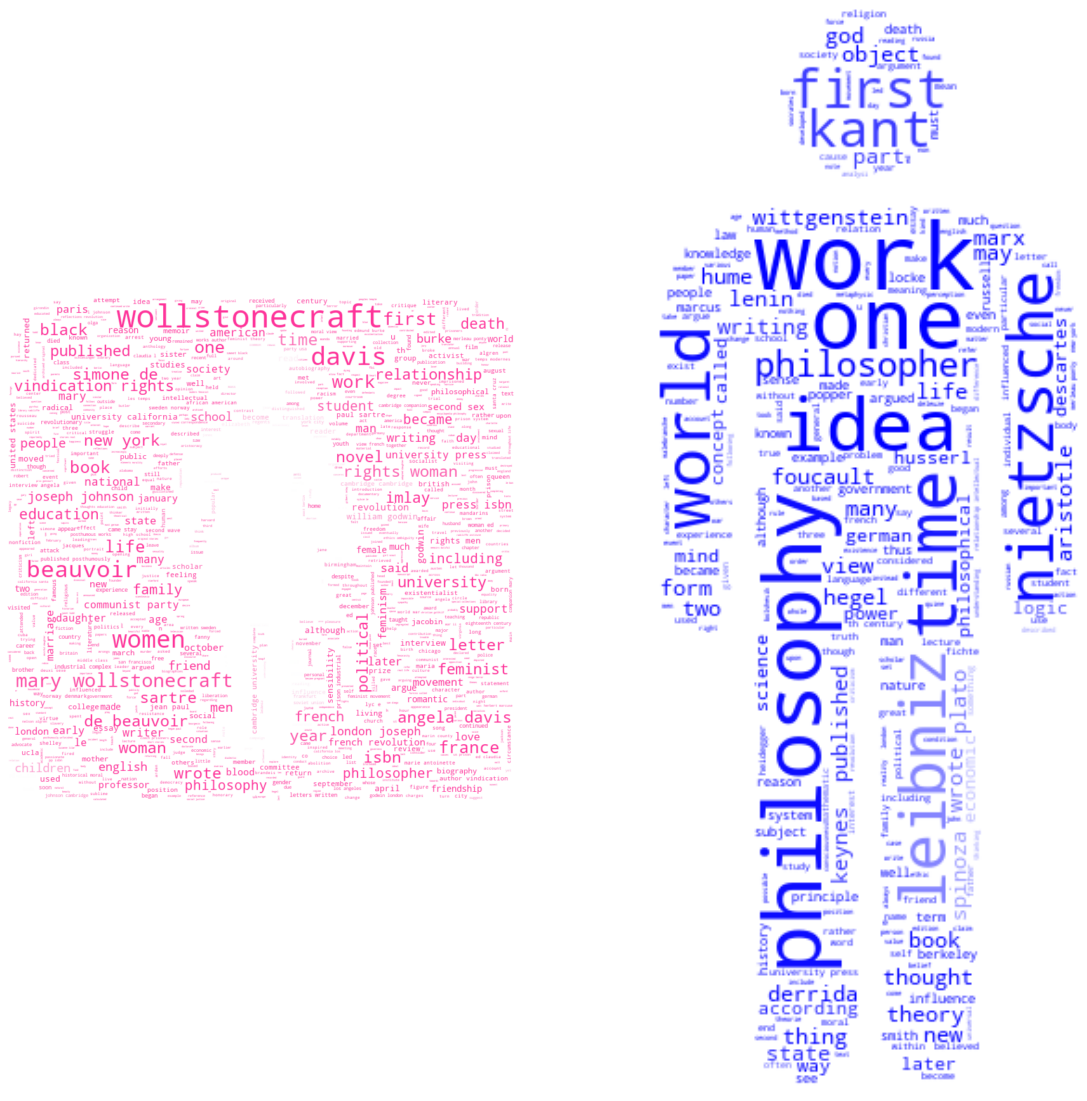

In [450]:
# wordcloud_wikipedia()

In [451]:
def wordcloud_google(**kwargs):    
    women_text = ' '.join(list(author_wiki_df[(author_wiki_df.sex=='female') & (~author_wiki_df.rem_sw.isna())].rem_sw))
    men_text = ' '.join(list(author_wiki_df[(author_wiki_df.sex=='male') & (~author_wiki_df.rem_sw.isna())].rem_sw))

    women_coloring = np.array(Image.open("../figs/women.png"))
    men_coloring = np.array(Image.open("../figs/men2.png"))

    wc_women = WordCloud(background_color="white",
                         max_words=250,
                         mask=women_coloring,
                         max_font_size=50,
                         random_state=123)
    wc_men = WordCloud(background_color="white",
                         max_words=1000,
                         mask=men_coloring,
                         max_font_size=50,
                         random_state=123)
    # generate word cloud
    wc_women.generate(women_text)
    wc_men.generate(men_text)

    # create coloring from image
    women_image_colors = ImageColorGenerator(women_coloring)
    men_image_colors = ImageColorGenerator(men_coloring)

    fig, ax = plt.subplots(1,2,figsize=(20,20))

    ax[0].imshow(wc_women.recolor(color_func=women_image_colors), interpolation="bilinear")
    ax[0].set_axis_off()

    ax[1].imshow(wc_men.recolor(color_func=men_image_colors), interpolation="bilinear")
    ax[1].set_axis_off()
    plt.show()

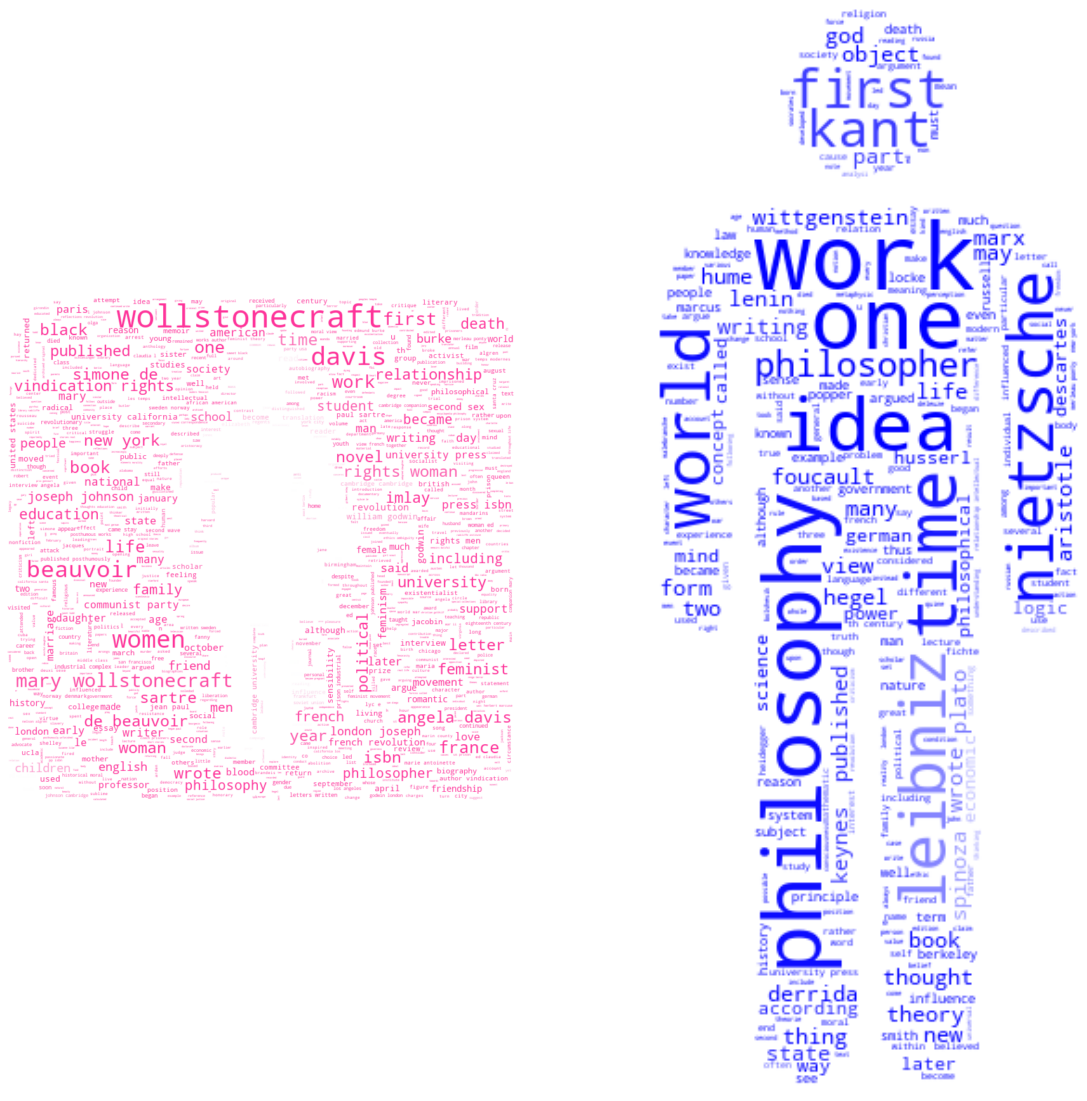

In [452]:
# wordcloud_google()

# overlap between genders (venn diagram)

In [453]:
def venn_wordcloud_data(**kwargs):
    women_rm_sw_text = ' '.join(list(data[(data.sex=='female') & (~data.rem_sw.isna())].rem_sw))
    men_rm_sw_text = ' '.join(list(data[(data.sex=='male') & (~data.rem_sw.isna())].rem_sw))

    women_splt = set(women_rm_sw_text.split())
    men_splt = set(men_rm_sw_text.split())
    just_women = set([x for x in women_splt if x not in men_splt])
    just_men = set([x for x in men_splt if x not in women_splt])
    men_and_women = just_women.intersection(just_men)

    women_fnl = just_women.union(men_and_women)
    men_fnl = just_men.union(men_and_women)

    def color_func(word, *args, **kwargs):
        if word in just_men:
            return "#0000ff" # blue1
        elif word in just_women:
            return "#FA33FF" # pink
        else:
            return "#737373" # gray6 (aka off-black)

    fig, ax = plt.subplots(figsize=(25, 25))
    fig.suptitle("Philosophy Texts", fontsize=25)

    sets = []
    for string in [women_rm_sw_text, men_rm_sw_text]:

        # get a word list
        words = string.split(' ')

        # remove non alphanumeric characters
        words = [''.join(ch for ch in word if ch.isalnum()) for word in words]

        # convert to all lower case
        words = [word.lower() for word in words]

        sets.append(set(words))

    # create visualisation
    out = venn2_wordcloud(sets, wordcloud_kwargs=dict(color_func=color_func), ax=ax)
    out

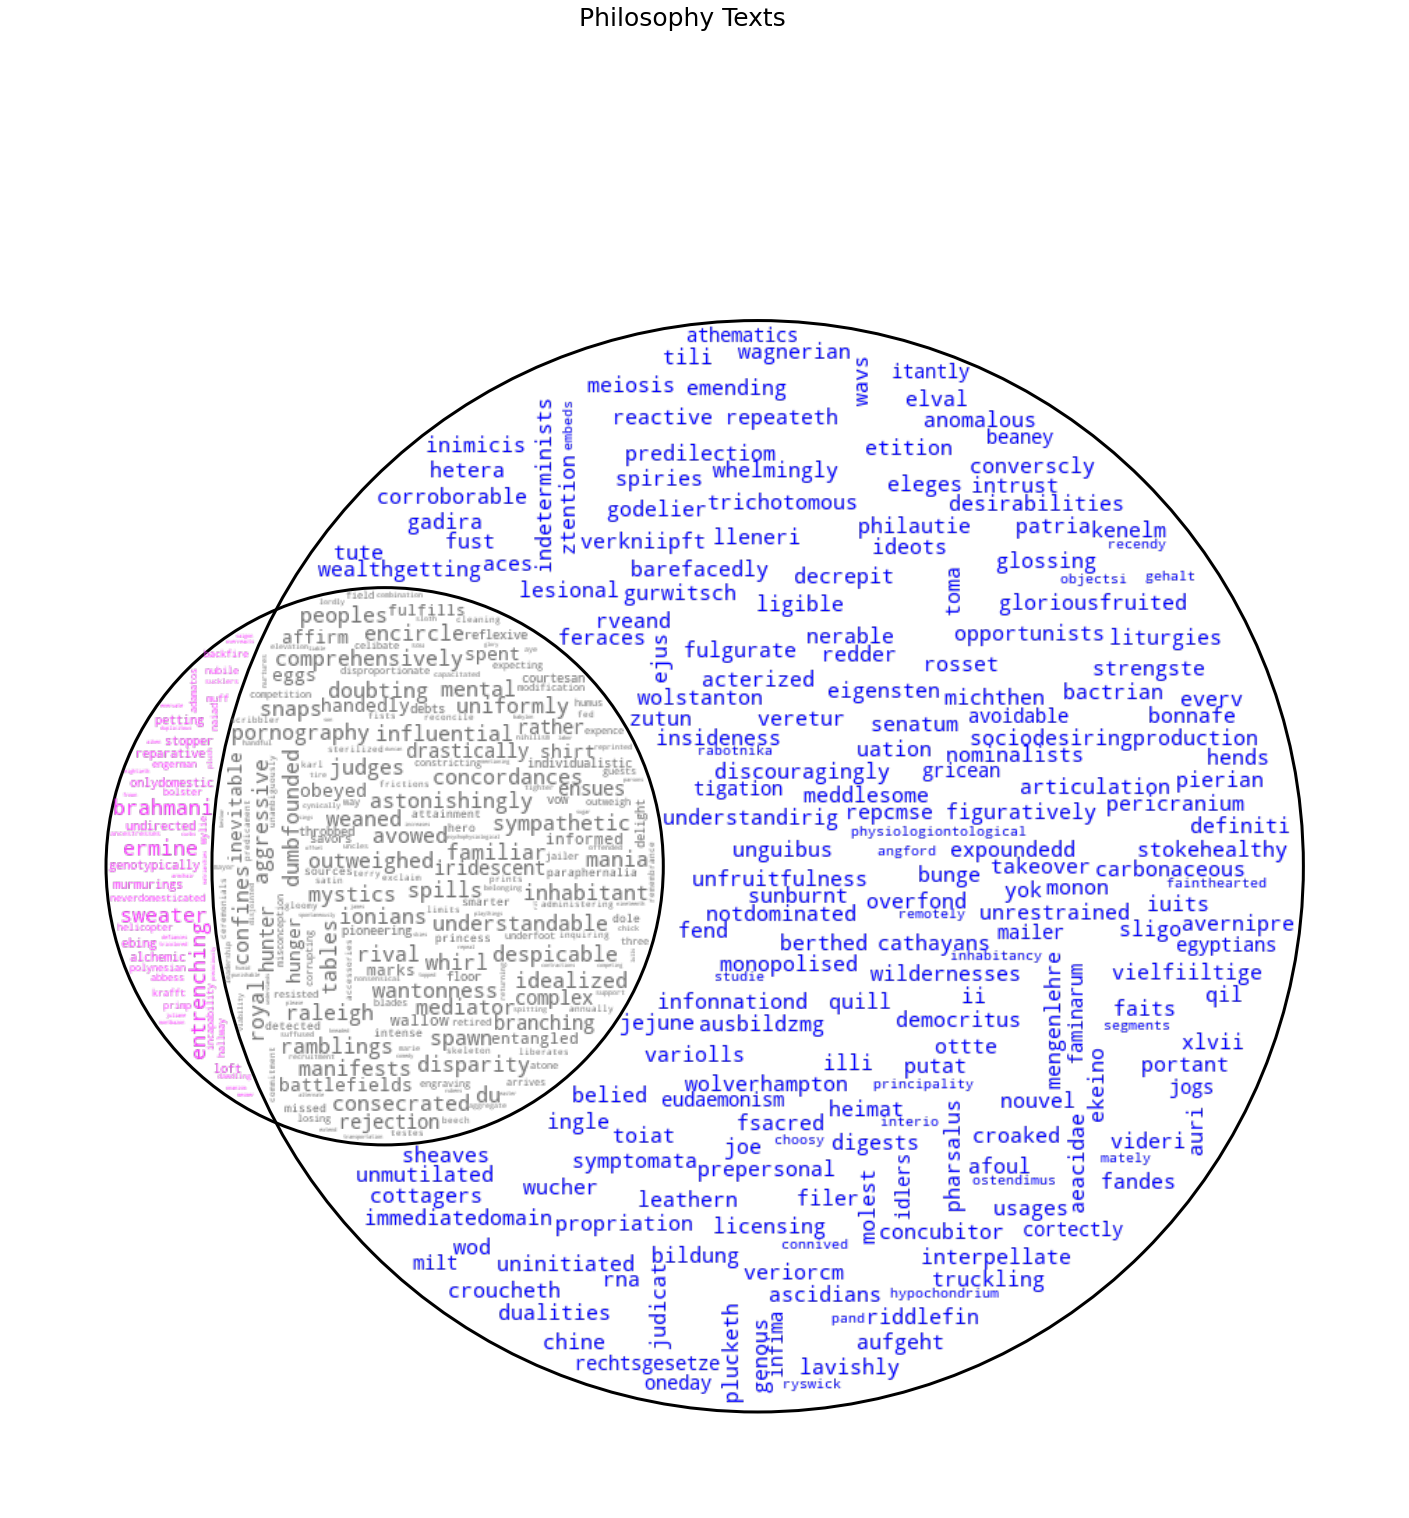

In [454]:
# venn_wordcloud_data()

In [411]:
def venn_wordcloud_wiki(**kwargs):
    women_rm_sw_text = ' '.join(list(author_wiki_df[(author_wiki_df.sex=='female') & (~author_wiki_df.rem_sw.isna())].rem_sw))
    men_rm_sw_text = ' '.join(list(author_wiki_df[(author_wiki_df.sex=='male') & (~author_wiki_df.rem_sw.isna())].rem_sw))

    women_splt = set(women_rm_sw_text.split())
    men_splt = set(men_rm_sw_text.split())
    just_women = set([x for x in women_splt if x not in men_splt])
    just_men = set([x for x in men_splt if x not in women_splt])
    men_and_women = just_women.intersection(just_men)

    women_fnl = just_women.union(men_and_women)
    men_fnl = just_men.union(men_and_women)

    def color_func(word, *args, **kwargs):
        if word in just_men:
            return "#0000ff" # blue1
        elif word in just_women:
            return "#FA33FF" # pink
        else:
            return "#737373" # gray6 (aka off-black)

    fig, ax = plt.subplots(figsize=(25, 25))
    fig.suptitle("Wikipedia Bios", fontsize=25)


    sets = []
    for string in [women_rm_sw_text, men_rm_sw_text]:

        # get a word list
        words = string.split(' ')

        # remove non alphanumeric characters
        words = [''.join(ch for ch in word if ch.isalnum()) for word in words]

        # convert to all lower case
        words = [word.lower() for word in words]

        sets.append(set(words))

    # create visualisation
    out = venn2_wordcloud(sets, wordcloud_kwargs=dict(color_func=color_func), ax=ax)
    out

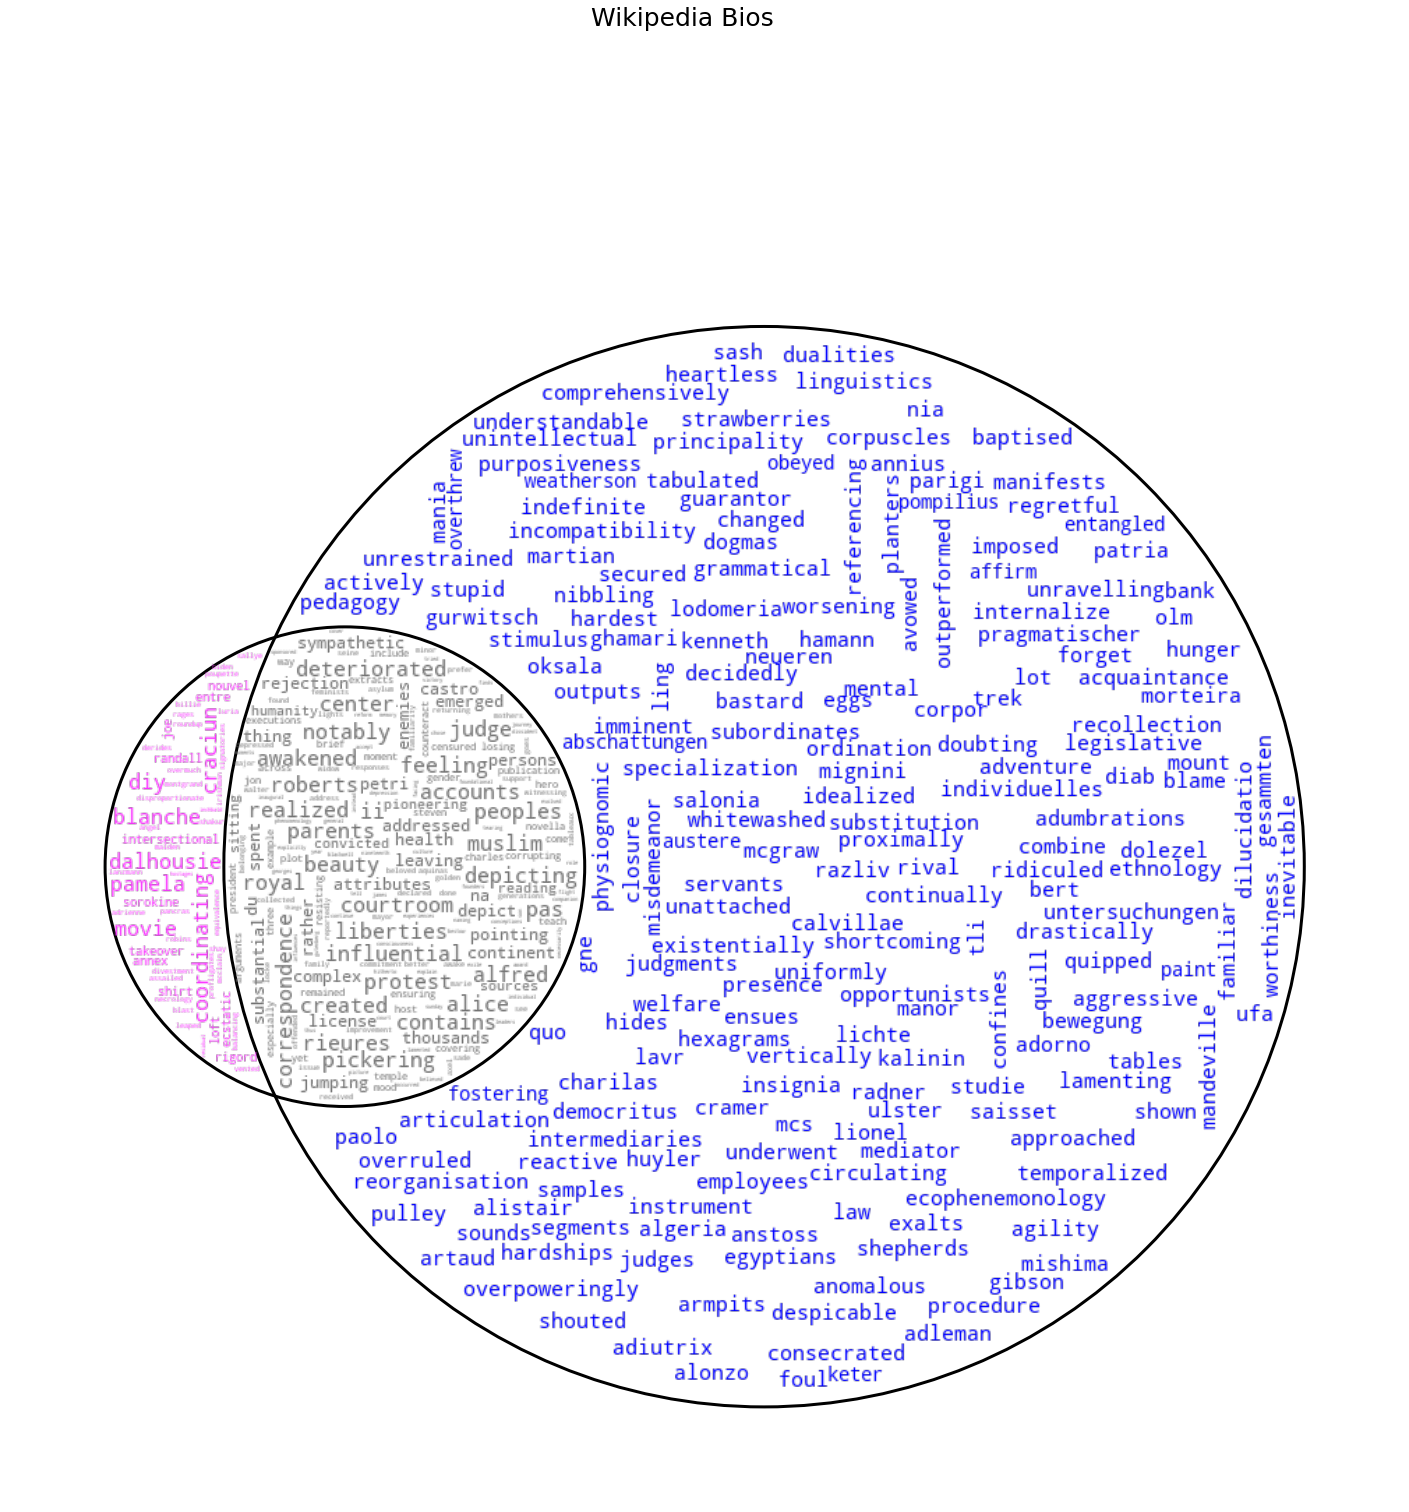

In [455]:
# venn_wordcloud_wiki()

In [412]:
def venn_wordcloud_google(**kwargs):
    women_rm_sw_text = ' '.join(list(google_data[(google_data.sex=='female') & (~google_data.rem_sw.isna())].rem_sw))
    men_rm_sw_text = ' '.join(list(google_data[(google_data.sex=='male') & (~google_data.rem_sw.isna())].rem_sw))

    women_splt = set(women_rm_sw_text.split())
    men_splt = set(men_rm_sw_text.split())
    just_women = set([x for x in women_splt if x not in men_splt])
    just_men = set([x for x in men_splt if x not in women_splt])
    men_and_women = just_women.intersection(just_men)

    women_fnl = just_women.union(men_and_women)
    men_fnl = just_men.union(men_and_women)

    def color_func(word, *args, **kwargs):
        if word in just_men:
            return "#0000ff" # blue1
        elif word in just_women:
            return "#FA33FF" # pink
        else:
            return "#737373" # gray

    fig, ax = plt.subplots(figsize=(25, 25))
    fig.suptitle("Google Search Results", fontsize=25)

    # venn2_wordcloud(sets, wordcloud_kwargs=dict(max_font_size=50, min_font_size=30), ax=ax2)
    # ax2.set_title('cloud')

    sets = []
    for string in [women_rm_sw_text, men_rm_sw_text]:

        # get a word list
        words = string.split(' ')

        # remove non alphanumeric characters
        words = [''.join(ch for ch in word if ch.isalnum()) for word in words]

        # convert to all lower case
        words = [word.lower() for word in words]

        sets.append(set(words))

    # create visualisation
    out = venn2_wordcloud(sets, wordcloud_kwargs=dict(color_func=color_func), ax=ax)
    out

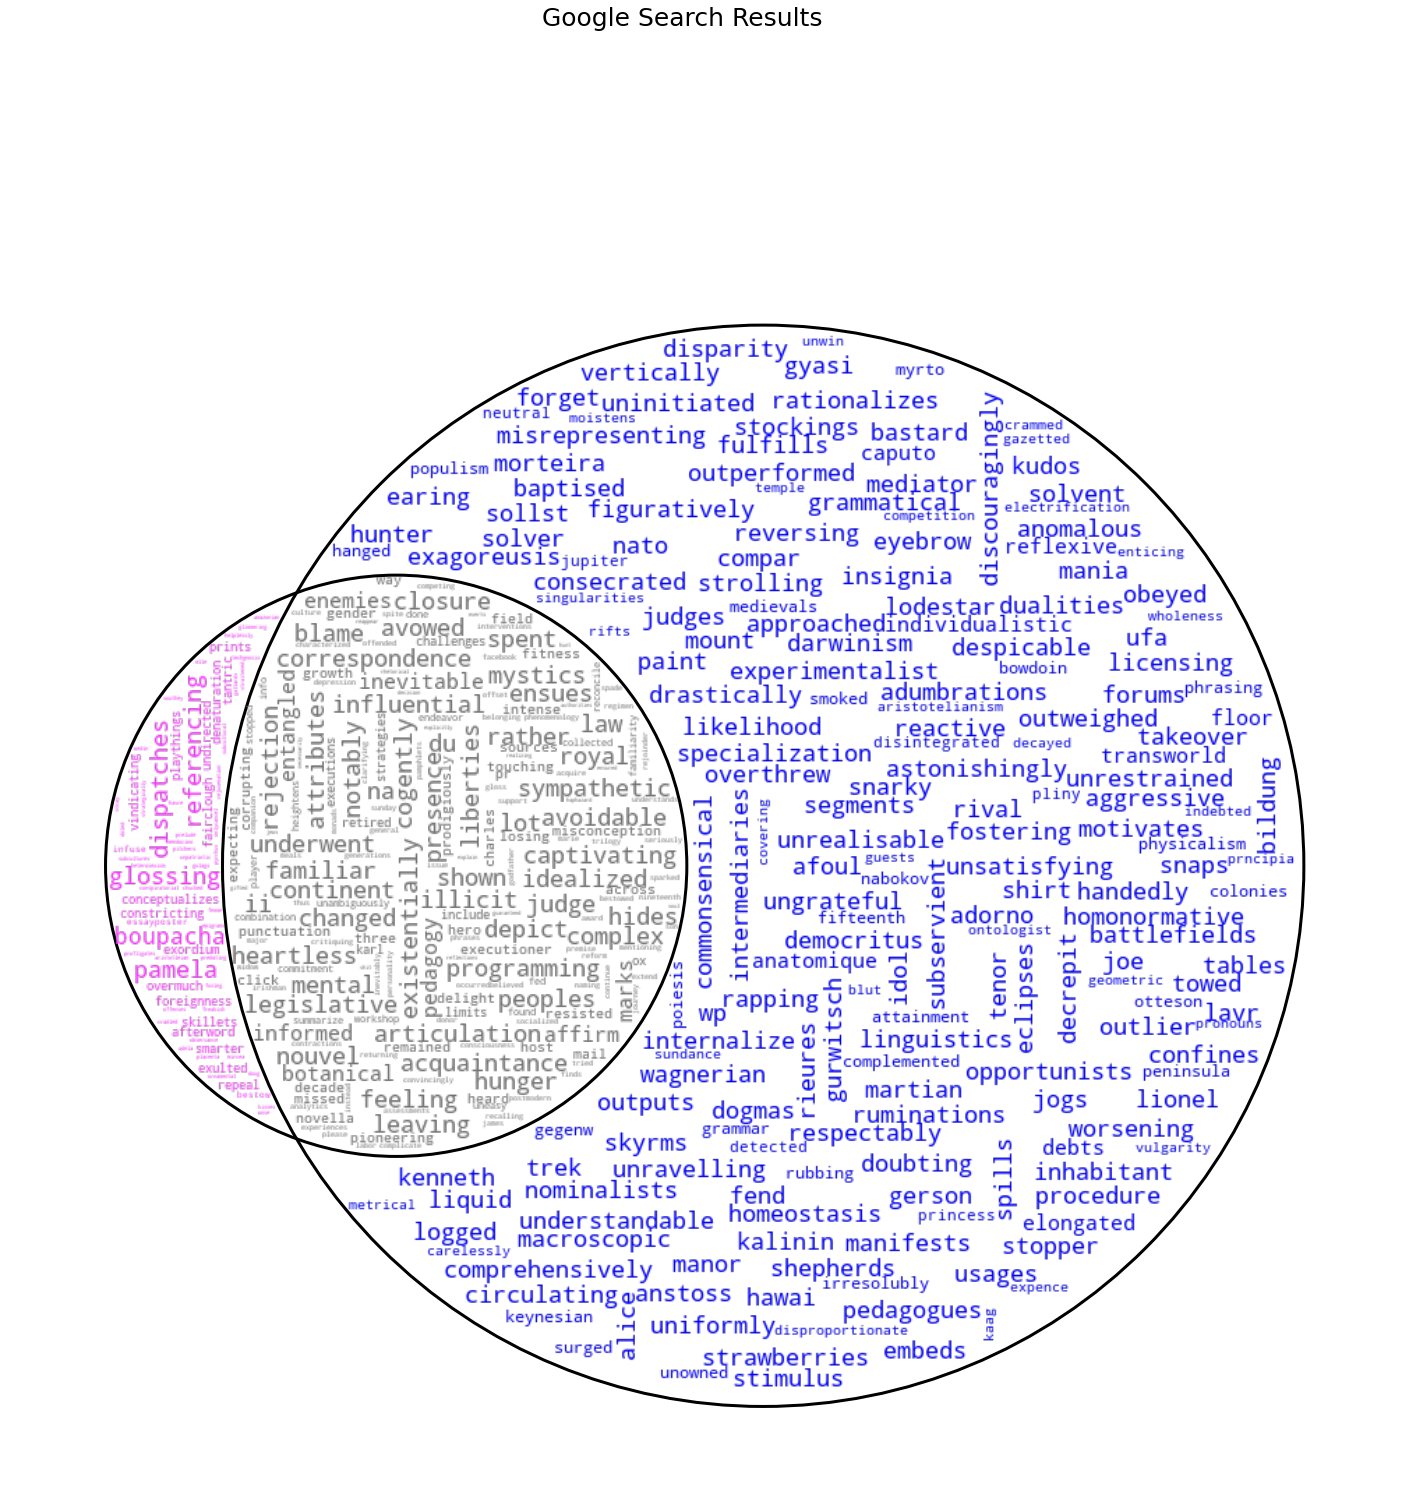

In [456]:
# venn_wordcloud_google()